In [22]:

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from joblib import delayed, Parallel
from tqdm import tqdm

# from sklearn.metrics import 
plt.rcParams['text.usetex'] = True


In [4]:
def RFClassifier(dfin, target, cols_to_drop, trees):
    df_clean = dfin.dropna(subset=target)
    X =df_clean.drop(columns=cols_to_drop)
    y =df_clean[target[0]]


    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)


    clf = RandomForestClassifier(
        n_estimators=trees, 
        random_state=42, 
        class_weight='balanced'  
    )
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    y_test_pred = clf.predict(X_test)

    report_train = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)#.get('accuracy')
    report_val = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)#.get('accuracy')
    report_test = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)#.get('accuracy')

    train_acc = report_train.get('accuracy')
    val_acc = report_val.get('accuracy')
    test_acc = report_test.get('accuracy')

    return [train_acc, val_acc, test_acc]




<Axes: >

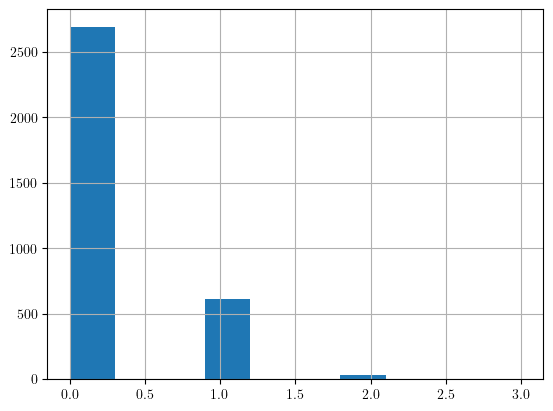

In [5]:
dataset = pd.read_csv('numeric_data_agri.csv')
dataset['ckd_code_sample_1'].hist()

# Q1
We are trying to predict CKD sample 1, based on all other variables. 

In [6]:
def RF_wrapper(tree):
    return RFClassifier(
        dfnum,
        ['ckd_code_sample_1'],
        ['ckd_code_sample_1', 'ckd__probable_sample_1', 'ckd_epi_sample_1'],
        trees=tree
    )

dfnum = pd.read_csv('numeric_data_agri.csv')
n_tree = np.linspace(1, 600, 59, dtype=int)
accs = np.zeros_like(n_tree)

accuracies = Parallel(n_jobs=-1)(
    delayed(RF_wrapper)(tree) for tree in tqdm(n_tree)
)

 37%|███▋      | 22/59 [00:20<00:00, 78.66it/s]

<>:7: SyntaxWarning: invalid escape sequence '\#'
<>:7: SyntaxWarning: invalid escape sequence '\#'
C:\Users\aksha\AppData\Local\Temp\ipykernel_6676\2829790154.py:7: SyntaxWarning: invalid escape sequence '\#'
  plt.xlabel('\#Trees')


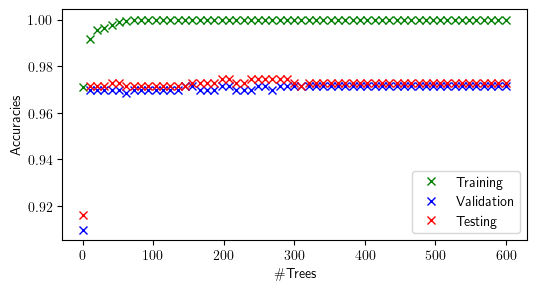

In [7]:
accuracies = np.array(accuracies)
plt.figure(figsize=(6, 3))
plt.plot(n_tree, accuracies[:,0], 'x', color='green', label='Training')
plt.plot(n_tree, accuracies[:,1], 'x', color='blue', label='Validation')
plt.plot(n_tree, accuracies[:,2], 'x', color='red', label='Testing')
# plt.plot(n_tree, accuracies, 'o', markersize=4, alpha=.6, c='red')
plt.xlabel('\#Trees')
plt.ylabel('Accuracies')
plt.legend()
plt.savefig(f'RF_err_#tree.png', dpi=450)

## n=100 trees

In [44]:
from sklearn.metrics import confusion_matrix

df_clean =dfnum.dropna(subset=['ckd_code_sample_1'])
X =df_clean.drop(columns=['ckd_code_sample_1', 'ckd__probable_sample_1', 'ckd_epi_sample_1' ])
y =df_clean['ckd_code_sample_1']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

cdk_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced'  
)
cdk_model.fit(X_train, y_train)
y_pred = cdk_model.predict(X_test)

print(classification_report(y_test, y_pred,zero_division=0)) 
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       539
         1.0       0.95      0.87      0.91       122
         2.0       0.00      0.00      0.00         6

    accuracy                           0.97       667
   macro avg       0.64      0.62      0.63       667
weighted avg       0.96      0.97      0.96       667

[[539   0   0]
 [ 16 106   0]
 [  0   6   0]]


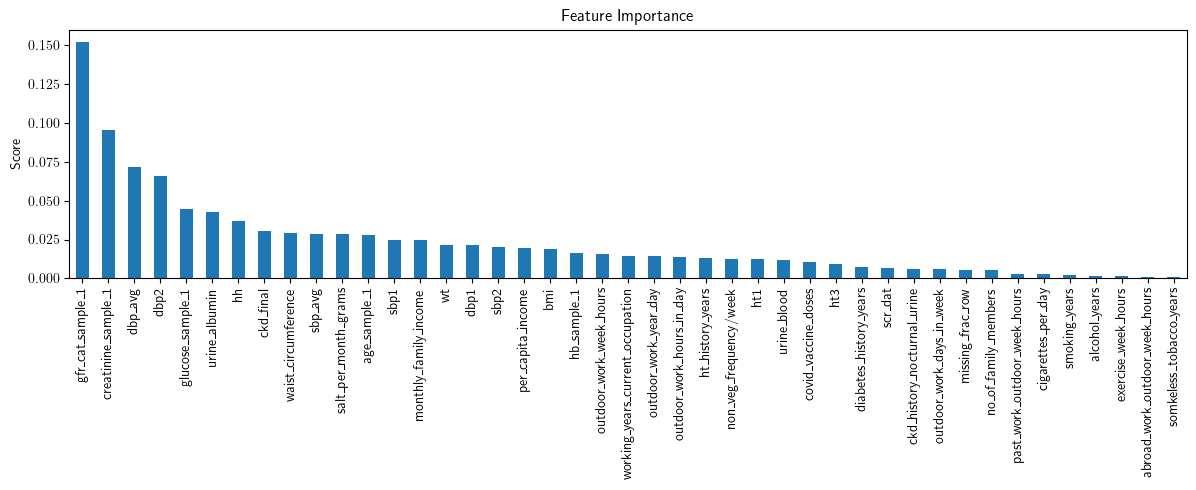

In [46]:

importances = pd.Series(cdk_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5))
plt.title("Feature Importance")
plt.ylabel("Score")
plt.tight_layout()
plt.savefig('feature_importance_cdk_rf.png', dpi=450)

plt.show()


c:\Users\aksha\.conda\envs\c138\Lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


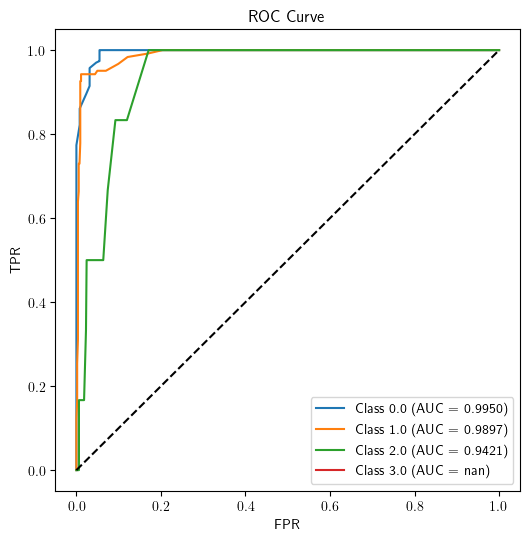

In [ ]:

y_proba = cdk_model.predict_proba(X_test)
classes = cdk_model.classes_

plt.figure(figsize=(6,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test == cls, y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.savefig('ROC_ckd_RF.png', dpi=450)
plt.show()


# Q2
Age group correlation with other features

In [19]:

dfnum2 = pd.read_csv('numeric_data_agri.csv')
bins = [18, 35, 50, 65, 100]
labels = ['18-34', '35-49', '50-64', '65+']

dfnum2['age_group'] = pd.cut(dfnum2['age_sample_1'], bins=bins, labels=labels, right=False)

In [20]:

df_clean =dfnum2.dropna(subset=['age_group'])
X =df_clean.drop(columns=['age_sample_1', 'age_group'])
y =df_clean['age_group']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

age_predictor = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced'  
)
age_predictor.fit(X_train, y_train)
y_pred = age_predictor.predict(X_test)

print(classification_report(y_test, y_pred,zero_division=0)) 
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

       18-34       0.74      0.41      0.53        94
       35-49       0.51      0.63      0.57       204
       50-64       0.49      0.65      0.56       231
         65+       0.68      0.29      0.41       135

    accuracy                           0.53       664
   macro avg       0.61      0.49      0.51       664
weighted avg       0.57      0.53      0.52       664

[[ 39  40  14   1]
 [  7 128  67   2]
 [  7  60 149  15]
 [  0  21  75  39]]


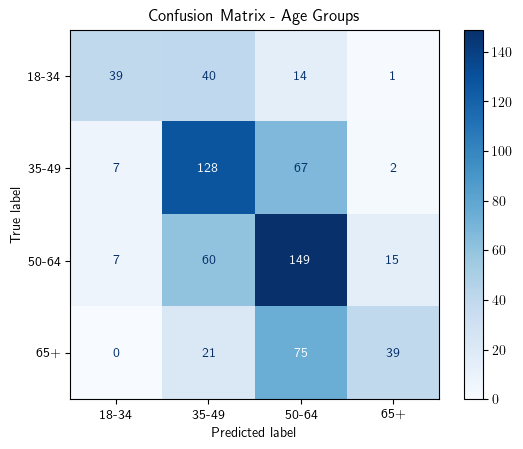

In [21]:

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
labels = df_clean['age_group'].cat.categories

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Age Groups")
plt.show()


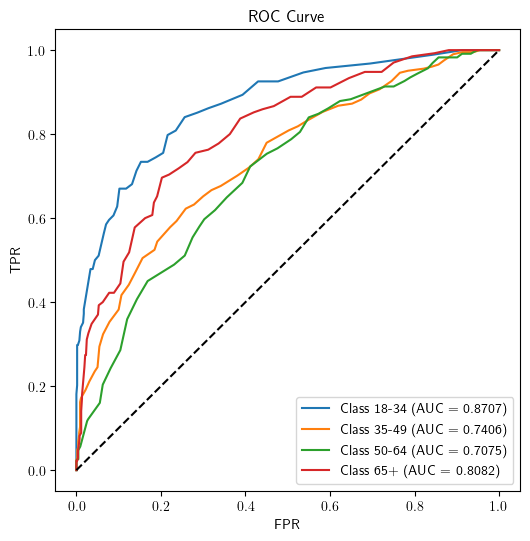

In [23]:
y_proba = age_predictor.predict_proba(X_test)
classes = age_predictor.classes_

plt.figure(figsize=(6,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test == cls, y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.savefig('ROC_age_RF.png', dpi=450)
plt.show()

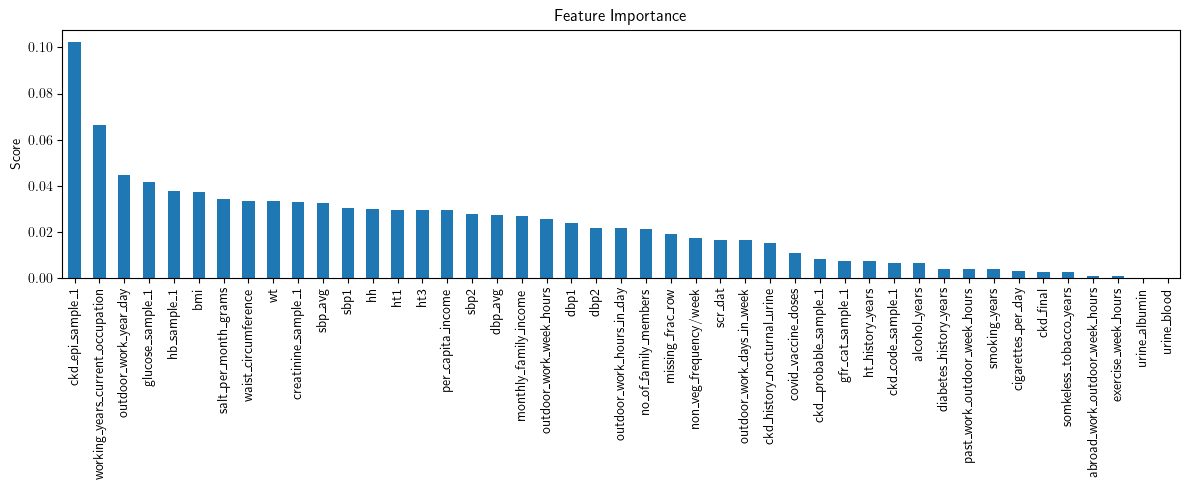

In [24]:
importances = pd.Series(age_predictor.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5))
plt.title("Feature Importance")
plt.ylabel("Score")
plt.tight_layout()
# plt.savefig('feature_importance_age.png', dpi=450)
plt.show()


## Age group vs CKD

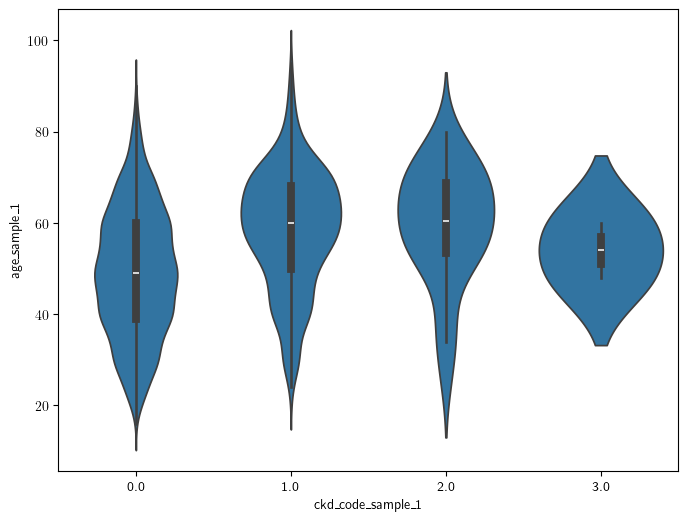

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.violinplot(x=dfnum2['ckd_code_sample_1'], y=dfnum2['age_sample_1'], data=df_clean)
plt.show()


# Rough Works
